In [1]:
!pip install numpy pillow matplotlib scikit-image requests tqdm

Processing images:   0%|          | 0/3 [00:00<?, ?it/s]

Iter 001 | Best fitness: 16.198449 | Best thresholds: [61, 116, 168]
Iter 013 | Best fitness: 16.209605 | Best thresholds: [59, 110, 171]
Iter 025 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 037 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 049 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 061 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 073 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 085 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 097 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 109 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]
Iter 120 | Best fitness: 16.211205 | Best thresholds: [61, 112, 171]


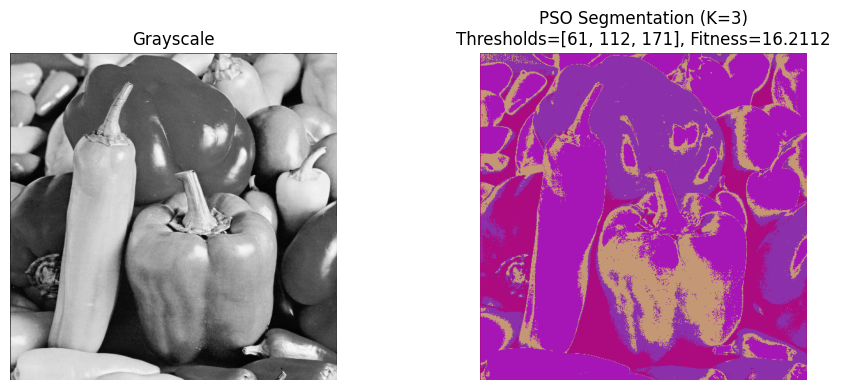

Processing images: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

[RESULT] sipi_1: thresholds=[61, 112, 171], fitness=16.211205
[WARN] Failed to download https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.09: cannot identify image file <_io.BytesIO object at 0x7948b49df470>
[WARN] Failed to download https://sipi.usc.edu/database/download.php?vol=texture&img=4.1.04: cannot identify image file <_io.BytesIO object at 0x7948b49df560>


In [3]:
"""
PSO for Image Segmentation (Multi-level Thresholding) using Kapur's Entropy
Dataset: Online images from the USC-SIPI Image Database (or any URLs you provide)

Dependencies:
    pip install numpy pillow matplotlib scikit-image requests tqdm

How it works (high level):
    - Convert image to grayscale [0..255]
    - For K thresholds, a solution vector is K integers: t1 < t2 < ... < tK
    - Fitness = Kapur entropy of resulting (K+1) classes (maximize)
    - PSO searches integer threshold combinations that maximize fitness
    - Apply best thresholds to segment the image and save results
"""

import os
import io
import math
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from typing import List, Tuple
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity

# ----------------------------
# Utilities: dataset download
# ----------------------------

def fetch_image_from_url(url: str) -> np.ndarray:
    """Download an image and return as float32 grayscale array in [0, 255]."""
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    img = Image.open(io.BytesIO(resp.content)).convert("RGB")
    arr = np.asarray(img, dtype=np.float32) / 255.0
    gray = rgb2gray(arr)  # returns [0..1]
    gray = rescale_intensity(gray, in_range='image', out_range=(0, 255)).astype(np.uint8)
    return gray

# ------------------------------------
# Kapur Entropy (fitness to maximize)
# ------------------------------------

def kapur_entropy(hist: np.ndarray, thresholds: List[int]) -> float:
    """
    Compute Kapur's entropy for multi-level thresholding.
    thresholds: sorted list of unique integers in [1, 254] (for 8-bit image)
    Returns: scalar entropy (higher is better)
    """
    # Ensure thresholds sorted & unique
    t = sorted(set(thresholds))
    if len(t) != len(thresholds):  # penalize invalid (duplicates)
        return -1e9

    # Histogram must be length 256, normalized
    p = hist.astype(np.float64)
    p = p / (p.sum() + 1e-12)

    # Split classes by thresholds
    cuts = [0] + t + [255]
    total_entropy = 0.0

    for i in range(len(cuts) - 1):
        a, b = cuts[i], cuts[i+1]
        # Note: bins inclusive on the left; make [a..b] with b inclusive
        # For Kapur, use p[a : b+1]
        segment = p[a:b+1]
        psum = segment.sum()
        if psum <= 0:
            # Empty class → zero contribution, but keep fitness finite
            continue
        # Normalize to class distribution and sum -q*log(q)
        q = segment / psum
        ent = -(q[q > 0] * np.log(q[q > 0] + 1e-12)).sum()
        total_entropy += ent

    return total_entropy

def image_histogram(image_gray: np.ndarray) -> np.ndarray:
    """Compute 256-bin histogram of an 8-bit grayscale image."""
    hist, _ = np.histogram(image_gray, bins=256, range=(0, 255))
    return hist

# ----------------------------
# Particle Swarm Optimization
# ----------------------------

class PSO:
    def __init__(
        self,
        dim: int,
        bounds: Tuple[int, int],
        fitness_fn,
        swarm_size: int = 30,
        w: float = 0.72,     # Inertia (common good default ~0.7)
        c1: float = 1.49,    # Cognitive
        c2: float = 1.49,    # Social
        iters: int = 100,
        seed: int = 42,
    ):
        """
        dim: number of thresholds (K)
        bounds: (low, high) inclusive integer range for each threshold (e.g., (1, 254))
        fitness_fn: function mapping position -> fitness (maximize)
        """
        self.dim = dim
        self.lo, self.hi = bounds
        self.fitness_fn = fitness_fn
        self.swarm_size = swarm_size
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.iters = iters
        self.rng = random.Random(seed)
        np.random.seed(seed)

        # Initialize integer positions (thresholds) and continuous velocities
        self.pos = np.vstack([
            np.sort(self.rng.choices(range(self.lo, self.hi), k=self.dim)).astype(np.float64)
            for _ in range(self.swarm_size)
        ])
        self.vel = np.random.uniform(-10, 10, size=(self.swarm_size, self.dim))

        # Evaluate initial
        self.pbest_pos = self.pos.copy()
        self.pbest_fit = np.array([self.fitness_fn(p.astype(int).tolist()) for p in self.pos])
        g_idx = int(np.argmax(self.pbest_fit))
        self.gbest_pos = self.pbest_pos[g_idx].copy()
        self.gbest_fit = float(self.pbest_fit[g_idx])

    def step(self):
        # Velocity & position update
        rp = np.random.rand(self.swarm_size, self.dim)
        rg = np.random.rand(self.swarm_size, self.dim)

        cognitive = self.c1 * rp * (self.pbest_pos - self.pos)
        social    = self.c2 * rg * (self.gbest_pos - self.pos)
        self.vel = self.w * self.vel + cognitive + social

        # Update positions (keep continuous, but we’ll round when evaluating)
        self.pos = self.pos + self.vel

        # Enforce bounds and sort thresholds (softly)
        self.pos = np.clip(self.pos, self.lo, self.hi)

        # Evaluate fitness on integer-rounded, strictly increasing thresholds
        # To encourage strict increase, sort and then nudge duplicates with small noise
        eval_pos = []
        for p in self.pos:
            q = np.sort(np.rint(p).astype(int))
            # Ensure unique by spreading within bounds (fallback if duplicates)
            for j in range(1, len(q)):
                if q[j] <= q[j-1]:
                    q[j] = min(self.hi, q[j-1] + 1)
            # If still out of bounds uniqueness fails, penalize in fitness function naturally
            eval_pos.append(q.tolist())

        fits = np.array([self.fitness_fn(th) for th in eval_pos])

        # Update personal bests
        improved_indices = np.where(fits > self.pbest_fit)[0]
        if len(improved_indices) > 0:
            self.pbest_fit[improved_indices] = fits[improved_indices]
            self.pbest_pos[improved_indices] = np.array([eval_pos[i] for i in improved_indices], dtype=np.float64)

        # Update global best
        g_idx = int(np.argmax(self.pbest_fit))
        if self.pbest_fit[g_idx] > self.gbest_fit:
            self.gbest_fit = float(self.pbest_fit[g_idx])
            self.gbest_pos = self.pbest_pos[g_idx].copy()

        return self.gbest_pos.copy(), self.gbest_fit

    def run(self, verbose: bool = True):
        history = []
        for it in range(self.iters):
            gpos, gfit = self.step()
            history.append((it+1, gfit))
            if verbose and (it % max(1, self.iters // 10) == 0 or it == self.iters - 1):
                print(f"Iter {it+1:03d} | Best fitness: {gfit:.6f} | Best thresholds: {gpos.astype(int).tolist()}")
        return self.gbest_pos.astype(int).tolist(), self.gbest_fit, history

# -----------------------------------
# Apply thresholds to segment image
# -----------------------------------

def apply_thresholds(image_gray: np.ndarray, thresholds: List[int]) -> np.ndarray:
    """
    Map grayscale image into (K+1) labels based on thresholds.
    Returns a label image with values {0..K}.
    """
    t = sorted(thresholds)
    seg = np.zeros_like(image_gray, dtype=np.uint8)
    prev = 0
    for i, th in enumerate(t):
        seg[(image_gray >= prev) & (image_gray <= th)] = i
        prev = th + 1
    seg[image_gray >= prev] = len(t)  # last class
    return seg

def colorize_labels(seg: np.ndarray) -> np.ndarray:
    """Simple color map for label image -> RGB for visualization."""
    K = seg.max() + 1
    rng = np.random.RandomState(0)
    palette = rng.randint(0, 255, size=(K, 3), dtype=np.uint8)
    out = palette[seg]
    return out

# ----------------------------
# Main experiment
# ----------------------------

def pso_segment_image(
    image: np.ndarray,
    K: int = 3,
    swarm_size: int = 40,
    iters: int = 120,
    w: float = 0.72,
    c1: float = 1.49,
    c2: float = 1.49,
    seed: int = 123,
    show_plot: bool = True,
    save_dir: str = "outputs",
    tag: str = "image",
):
    os.makedirs(save_dir, exist_ok=True)

    hist = image_histogram(image)

    def fitness(thresholds: List[int]) -> float:
        # Penalize invalid thresholds quickly (must be inside 1..254 and strictly increasing)
        if any(t <= 0 or t >= 255 for t in thresholds):
            return -1e9
        if any(thresholds[i] >= thresholds[i+1] for i in range(len(thresholds) - 1)):
            return -1e9
        return kapur_entropy(hist, thresholds)

    pso = PSO(
        dim=K,
        bounds=(1, 254),
        fitness_fn=fitness,
        swarm_size=swarm_size,
        w=w, c1=c1, c2=c2,
        iters=iters,
        seed=seed
    )

    best_thresholds, best_fit, history = pso.run(verbose=True)
    seg = apply_thresholds(image, best_thresholds)
    seg_rgb = colorize_labels(seg)

    # Save results
    base = os.path.join(save_dir, f"{tag}_K{K}")
    Image.fromarray(image).save(base + "_gray.png")
    Image.fromarray(seg_rgb).save(base + "_seg.png")

    # Plot
    if show_plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(seg_rgb)
        plt.title(f"PSO Segmentation (K={K})\nThresholds={best_thresholds}, Fitness={best_fit:.4f}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(base + "_viz.png", dpi=150)
        plt.show()

    return best_thresholds, best_fit, history

def main():
    # Example online dataset (USC-SIPI sample images).
    # You can add/replace with any image URLs you like.
    urls = [
        # Peppers (classic test image)
        "https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07",
        # Boat
        "https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.09",
        # Lena-like (Barbara)
        "https://sipi.usc.edu/database/download.php?vol=texture&img=4.1.04"
    ]

    for idx, url in enumerate(tqdm(urls, desc="Processing images")):
        try:
            img = fetch_image_from_url(url)
        except Exception as e:
            print(f"[WARN] Failed to download {url}: {e}")
            continue

        # Run PSO multi-thresholding; adjust K for coarser/finer segmentation
        K = 3 if idx == 0 else 4
        tag = f"sipi_{idx+1}"
        best_thresholds, best_fit, history = pso_segment_image(
            img,
            K=K,
            swarm_size=40,
            iters=120,
            w=0.72, c1=1.49, c2=1.49,
            seed=123 + idx,
            show_plot=True,
            save_dir="outputs",
            tag=tag
        )
        print(f"[RESULT] {tag}: thresholds={best_thresholds}, fitness={best_fit:.6f}")

if __name__ == "__main__":
    main()